In [20]:
import logging
import pandas as pd
from sklearn.model_selection import train_test_split
import os.path
from os import path
import pandas as pd
import numpy as np
import base64
import re
import matplotlib.pyplot as plt

In [2]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [3]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
file_name = "poems_with_new_tags.zip"
poem_df = pd.read_csv('poems_with_new_tags.zip', compression='zip', header=0, quotechar='"')


In [5]:
poems_info = poem_df.drop(['star','author_stars','tags','tags_list','new_tags','new_first_tag'], axis=1)

In [6]:
poems_info.head()

,content,dynasty,author,title,写物,劝勉,家庭,快乐,悲苦,政治,朋友,游玩
0,《吴都赋》云：“户藏烟浦，家具画船。”唯吴兴为然。春游之盛，西湖未能过也。己酉岁，予与萧时父...,宋代,姜夔,琵琶仙·《吴都赋》云：「户藏烟浦,0,0,0,0,0,1,0,1
1,《廿一史弹词》第三段说秦汉开场词滚滚长江东逝水，浪花淘尽英雄。是非成败转头空。青山依旧在，几...,明代,杨慎,临江仙·滚滚长江东逝水,1,1,0,0,1,1,0,0
2,《水经》云：“彭蠡之口有石钟山焉。”郦元以为下临深潭，微风鼓浪，水石相搏，声如洪钟。是说也，...,宋代,苏轼,石钟山记,1,0,0,0,0,1,0,1
3,【序】辛亥之冬，予载雪诣石湖。止既月，授简索句，且征新声，作此两曲。石湖把玩不已，使工妓隶习...,宋代,姜夔,暗香疏影,0,1,0,0,0,0,0,0
4,〔一枝花〕 攀出墙朵朵花，折临路枝枝柳。花攀红蕊嫩，柳折翠条柔，浪子风流。凭着我折柳攀花手...,元代,关汉卿,【南吕】一枝花不伏老,1,0,0,1,1,0,0,0


In [7]:
OUTPUT_COLUMSN=['写物', '劝勉', '家庭', '快乐', '悲苦', '政治', '朋友', '游玩']

In [8]:
data, data_test = train_test_split(poems_info, test_size = 0.2)

In [9]:
# Name of the BERT model to use
model_name = 'bert-base-chinese'
# Max length of tokens
max_length = 100
# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False
# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-chinese were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-chinese.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [10]:
data.columns

Index(['content', 'dynasty', 'author', 'title', '写物', '劝勉', '家庭', '快乐', '悲苦',
       '政治', '朋友', '游玩'],
      dtype='object')

In [11]:
bert = transformer_model.layers[0]
# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}
# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)
# Then build your model output
#'写物', '劝勉', '家庭', '快乐', '悲苦', '政治', '朋友', '游玩'
object_ = Dense(units=len(data['写物'].value_counts()), 
                kernel_initializer=TruncatedNormal(stddev=config.initializer_range),
                name='object_')(pooled_output)
encourage_ = Dense(units=len(data['劝勉'].value_counts()), 
                   kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
                   name='encourage_')(pooled_output)
family_ = Dense(units=len(data['家庭'].value_counts()), 
                kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
                name='family_')(pooled_output)
happiness_ = Dense(units=len(data['快乐'].value_counts()), 
                   kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
                   name='happiness_')(pooled_output)
sadness_ = Dense(units=len(data['悲苦'].value_counts()), 
                 kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
                 name='sadness_')(pooled_output)
policy_ = Dense(units=len(data['政治'].value_counts()), 
                kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
                name='policy_')(pooled_output)
friend_ = Dense(units=len(data['朋友'].value_counts()), 
                kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
                name='friend_')(pooled_output)
travel_ = Dense(units=len(data['游玩'].value_counts()), 
                kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
                name='travel_')(pooled_output)

outputs = {'object_': object_, 'encourage_': encourage_, 'family_':family_, 'happiness_':happiness_,\
          'sadness_': sadness_, 'policy_': policy_, 'friend_': friend_, 'travel_': travel_}
# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')
# Take a look at the model
model.summary()

Model: "BERT_MultiLabel_MultiClass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 102267648   input_ids[0][0]                  
__________________________________________________________________________________________________
pooled_output (Dropout)         (None, 768)          0           bert[0][1]                       
__________________________________________________________________________________________________
encourage_ (Dense)              (None, 2)            1538        pooled_output[0][0]              
_________________________________________________________________________

In [ ]:
# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = {'object_': CategoricalCrossentropy(from_logits = False), 
        'encourage_': CategoricalCrossentropy(from_logits = False), 
        'family_':CategoricalCrossentropy(from_logits = False), 
        'happiness_':CategoricalCrossentropy(from_logits = False),
        'sadness_': CategoricalCrossentropy(from_logits = False), 
        'policy_': CategoricalCrossentropy(from_logits = False), 
        'friend_': CategoricalCrossentropy(from_logits = False), 
        'travel_': CategoricalCrossentropy(from_logits = False)}
metric = {'object_': CategoricalAccuracy('accuracy'), 
        'encourage_': CategoricalAccuracy('accuracy'), 
        'family_':CategoricalAccuracy('accuracy'), 
        'happiness_':CategoricalAccuracy('accuracy'),
        'sadness_': CategoricalAccuracy('accuracy'), 
        'policy_': CategoricalAccuracy('accuracy'), 
        'friend_': CategoricalAccuracy('accuracy'), 
        'travel_': CategoricalAccuracy('accuracy')}
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)
# Ready output data for the model
##'写物', '劝勉', '家庭', '快乐', '悲苦', '政治', '朋友', '游玩'
object_y = to_categorical(data['写物'])
encourage_y = to_categorical(data['劝勉'])
family_y = to_categorical(data['家庭'])
happiness_y = to_categorical(data['快乐'])
sadness_y = to_categorical(data['悲苦'])
policy_y = to_categorical(data['政治'])
friend_y = to_categorical(data['朋友'])
travel_y =to_categorical(data['游玩'])
y_list = {'object_': object_y, 'encourage_': encourage_y, 'family_':family_y, 
          'happiness_':happiness_y,'sadness_': sadness_y, 'policy_': policy_y, 
          'friend_': friend_y, 'travel_': travel_y}
# Tokenize the input (takes some time)
x = tokenizer(
    text=data['content'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y=y_list,
    validation_split=0.2,
    batch_size=32,
    epochs=10)

Epoch 1/10
123/123 [==============================] - 1775s 14s/step - loss: 13.5904 - encourage__loss: 0.6220 - family__loss: 2.1511 - friend__loss: 0.8622 - happiness__loss: 0.5037 - object__loss: 0.6808 - policy__loss: 0.6980 - sadness__loss: 7.5724 - travel__loss: 0.5002 - encourage__accuracy: 0.2139 - family__accuracy: 0.0993 - friend__accuracy: 0.7940 - happiness__accuracy: 0.1351 - object__accuracy: 0.3772 - policy__accuracy: 0.3544 - sadness__accuracy: 0.5481 - travel__accuracy: 0.8048 - val_loss: 14.8123 - val_encourage__loss: 0.7142 - val_family__loss: 3.0685 - val_friend__loss: 0.4878 - val_happiness__loss: 0.4702 - val_object__loss: 0.6633 - val_policy__loss: 0.6904 - val_sadness__loss: 7.9188 - val_travel__loss: 0.7990 - val_encourage__accuracy: 0.2518 - val_family__accuracy: 0.0983 - val_friend__accuracy: 0.7943 - val_happiness__accuracy: 0.1494 - val_object__accuracy: 0.3726 - val_policy__accuracy: 0.3859 - val_sadness__accuracy: 0.5374 - val_travel__accuracy: 0.8117
Epo

123/123 [==============================] - 1051s 9s/step - loss: 4.1312 - encourage__loss: 0.4760 - family__loss: 0.4123 - friend__loss: 0.5080 - happiness__loss: 0.4957 - object__loss: 0.6076 - policy__loss: 0.5242 - sadness__loss: 0.6164 - travel__loss: 0.4910 - encourage__accuracy: 0.7848 - family__accuracy: 0.9007 - friend__accuracy: 0.2078 - happiness__accuracy: 0.8713 - object__accuracy: 0.2615 - policy__accuracy: 0.1753 - sadness__accuracy: 0.2462 - travel__accuracy: 0.1968 - val_loss: 8.1973 - val_encourage__loss: 0.8037 - val_family__loss: 0.4502 - val_friend__loss: 0.6411 - val_happiness__loss: 1.1157 - val_object__loss: 1.1812 - val_policy__loss: 2.3461 - val_sadness__loss: 1.0969 - val_travel__loss: 0.5624 - val_encourage__accuracy: 0.7451 - val_family__accuracy: 0.9017 - val_friend__accuracy: 0.2129 - val_happiness__accuracy: 0.8434 - val_object__accuracy: 0.3961 - val_policy__accuracy: 0.3777 - val_sadness__accuracy: 0.3685 - val_travel__accuracy: 0.1914
Epoch 10/10
102/1

In [13]:
# Ready test data
test_object_y = to_categorical(data_test['写物'])
test_encourage_y = to_categorical(data_test['劝勉'])
test_family_y = to_categorical(data_test['家庭'])
test_happiness_y = to_categorical(data_test['快乐'])
test_sadness_y = to_categorical(data_test['悲苦'])
test_policy_y = to_categorical(data_test['政治'])
test_friend_y = to_categorical(data_test['朋友'])
test_travel_y =to_categorical(data_test['游玩'])
test_x = tokenizer(
    text=data_test['content'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)



In [14]:
# Run evaluation
test_y_list = {'object_': test_object_y, 'encourage_': test_encourage_y, 'family_':test_family_y, 
          'happiness_':test_happiness_y,'sadness_': test_sadness_y, 'policy_': test_policy_y, 
          'friend_': test_friend_y, 'travel_': test_travel_y}
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y=test_y_list
)

39/39 [==============================] - 101s 3s/step - loss: 5.4043 - encourage__loss: 0.6496 - family__loss: 0.3929 - friend__loss: 0.5752 - happiness__loss: 0.7650 - object__loss: 0.7017 - policy__loss: 0.7116 - sadness__loss: 1.0343 - travel__loss: 0.5740 - encourage__accuracy: 0.2128 - family__accuracy: 0.0917 - friend__accuracy: 0.7905 - happiness__accuracy: 0.1252 - object__accuracy: 0.3592 - policy__accuracy: 0.3699 - sadness__accuracy: 0.6563 - travel__accuracy: 0.8052


In [27]:
model_fit_history = pd.DataFrame(history.history)

In [29]:
model_fit_history.columns

Index(['loss', 'encourage__loss', 'family__loss', 'friend__loss',
       'happiness__loss', 'object__loss', 'policy__loss', 'sadness__loss',
       'travel__loss', 'encourage__accuracy', 'family__accuracy',
       'friend__accuracy', 'happiness__accuracy', 'object__accuracy',
       'policy__accuracy', 'sadness__accuracy', 'travel__accuracy', 'val_loss',
       'val_encourage__loss', 'val_family__loss', 'val_friend__loss',
       'val_happiness__loss', 'val_object__loss', 'val_policy__loss',
       'val_sadness__loss', 'val_travel__loss', 'val_encourage__accuracy',
       'val_family__accuracy', 'val_friend__accuracy',
       'val_happiness__accuracy', 'val_object__accuracy',
       'val_policy__accuracy', 'val_sadness__accuracy',
       'val_travel__accuracy'],
      dtype='object')

In [35]:
col_acc = model_fit_history.loc[: , "encourage__accuracy":"travel__accuracy"]
col_val_acc = model_fit_history.loc[: , "val_encourage__accuracy":"val_travel__accuracy"]
col_loss = model_fit_history.loc[: , "encourage__loss":"travel__loss"]
col_val_loss = model_fit_history.loc[: , "val_encourage__loss":"val_travel__loss"]
# df['salary_mean'] = col.mean(axis=1)
model_fit_history['acc'] = col_acc.mean(axis=1)
model_fit_history['val_acc'] = col_val_acc.mean(axis=1)
model_fit_history['loss'] = col_loss.mean(axis=1)
model_fit_history['val_loss'] = col_val_loss.mean(axis=1)

In [38]:
model_fit_history_subset = model_fit_history[['acc','val_acc','loss','val_loss']]

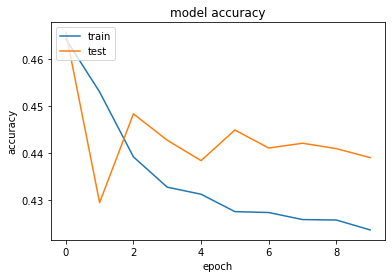

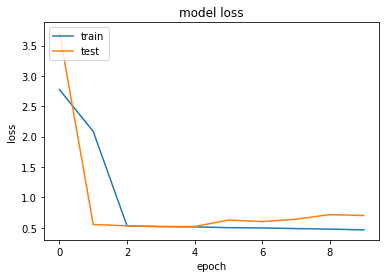

In [39]:
import matplotlib.pyplot as plt

plt.plot(model_fit_history_subset['acc'])
plt.plot(model_fit_history_subset['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(model_fit_history_subset['loss'])
plt.plot(model_fit_history_subset['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [15]:
model_eval

[5.404347896575928,
 0.6496298909187317,
 0.39292004704475403,
 0.5752416253089905,
 0.7649996876716614,
 0.7016807794570923,
 0.7116059064865112,
 1.0342761278152466,
 0.573994517326355,
 0.21276596188545227,
 0.09165302664041519,
 0.7905073761940002,
 0.12520457804203033,
 0.3592471480369568,
 0.3698854446411133,
 0.6563011407852173,
 0.8052372932434082]

In [19]:
# model.save("multi-label-model")

AttributeError: 'Functional' object has no attribute 'save_model'

In [16]:
loaded_model = load_model('multi-label-model')

In [17]:
loaded_model_eval = loaded_model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y=test_y_list
)

39/39 [==============================] - 100s 3s/step - loss: 3.0370 - encourage__loss: 0.3496 - family__loss: 0.2441 - friend__loss: 0.3287 - happiness__loss: 0.2842 - object__loss: 0.5102 - policy__loss: 0.4813 - sadness__loss: 0.5003 - travel__loss: 0.3386 - encourage__encourage__accuracy: 0.8658 - family__family__accuracy: 0.9182 - friend__friend__accuracy: 0.8773 - happiness__happiness__accuracy: 0.8936 - object__object__accuracy: 0.7651 - policy__policy__accuracy: 0.7930 - sadness__sadness__accuracy: 0.7823 - travel__travel__accuracy: 0.8732


In [18]:
loaded_model_eval

[3.036978006362915,
 0.3496300280094147,
 0.24406306445598602,
 0.3287423253059387,
 0.2842422425746918,
 0.5101723074913025,
 0.48128652572631836,
 0.5002656579017639,
 0.3385762870311737,
 0.865793764591217,
 0.9181669354438782,
 0.8772504329681396,
 0.8936170339584351,
 0.765139102935791,
 0.792962372303009,
 0.7823240756988525,
 0.8731587529182434]

In [ ]:
keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)


In [24]:
# prediction=model.predict(test_x['input_ids'])

In [28]:
prediction['encourage_'][9]

array([ 1.106571 , -1.1924883], dtype=float32)

In [9]:
data_test.head()

NameError: name 'data_test' is not defined